In [33]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
print(os.listdir("/kaggle/input/plantvillage/PlantVillage"))
labelNames = os.listdir("/kaggle/input/plantvillage/PlantVillage")
print(len(labelNames))

['Potato___Early_blight', 'Tomato_Septoria_leaf_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_healthy', 'Pepper__bell___Bacterial_spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato_Leaf_Mold', 'Pepper__bell___healthy', 'Tomato__Target_Spot', 'Potato___Late_blight', 'Tomato__Tomato_mosaic_virus', 'Potato___healthy', 'Tomato_Bacterial_spot']
15


In [34]:
data = []
labels = []

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        try:
            image = cv2.imread(os.path.join(dirname, filename))
            image_array = Image.fromarray(image , 'RGB')
            resize_img = image_array.resize((50 , 50))
            rotated45 = resize_img.rotate(45)
            rotated75 = resize_img.rotate(75)
            blur = cv2.blur(np.array(resize_img) ,(10,10))
            data.append(np.array(resize_img))
            data.append(np.array(rotated45))
            data.append(np.array(rotated75))
            data.append(np.array(blur))
            labelName = dirname.split('/')[-1]
            labels.append(labelNames.index(labelName))
            labels.append(labelNames.index(labelName))
            labels.append(labelNames.index(labelName))
            labels.append(labelNames.index(labelName))
        
        except AttributeError:
            print('')

In [35]:
plants = np.array(data)
labels = np.array(labels)

np.save('Plants' , plants)
np.save('Labels' , labels)
print('Plants : {} | labels : {}'.format(plants.shape , labels.shape))

Plants : (82552, 50, 50, 3) | labels : (82552,)


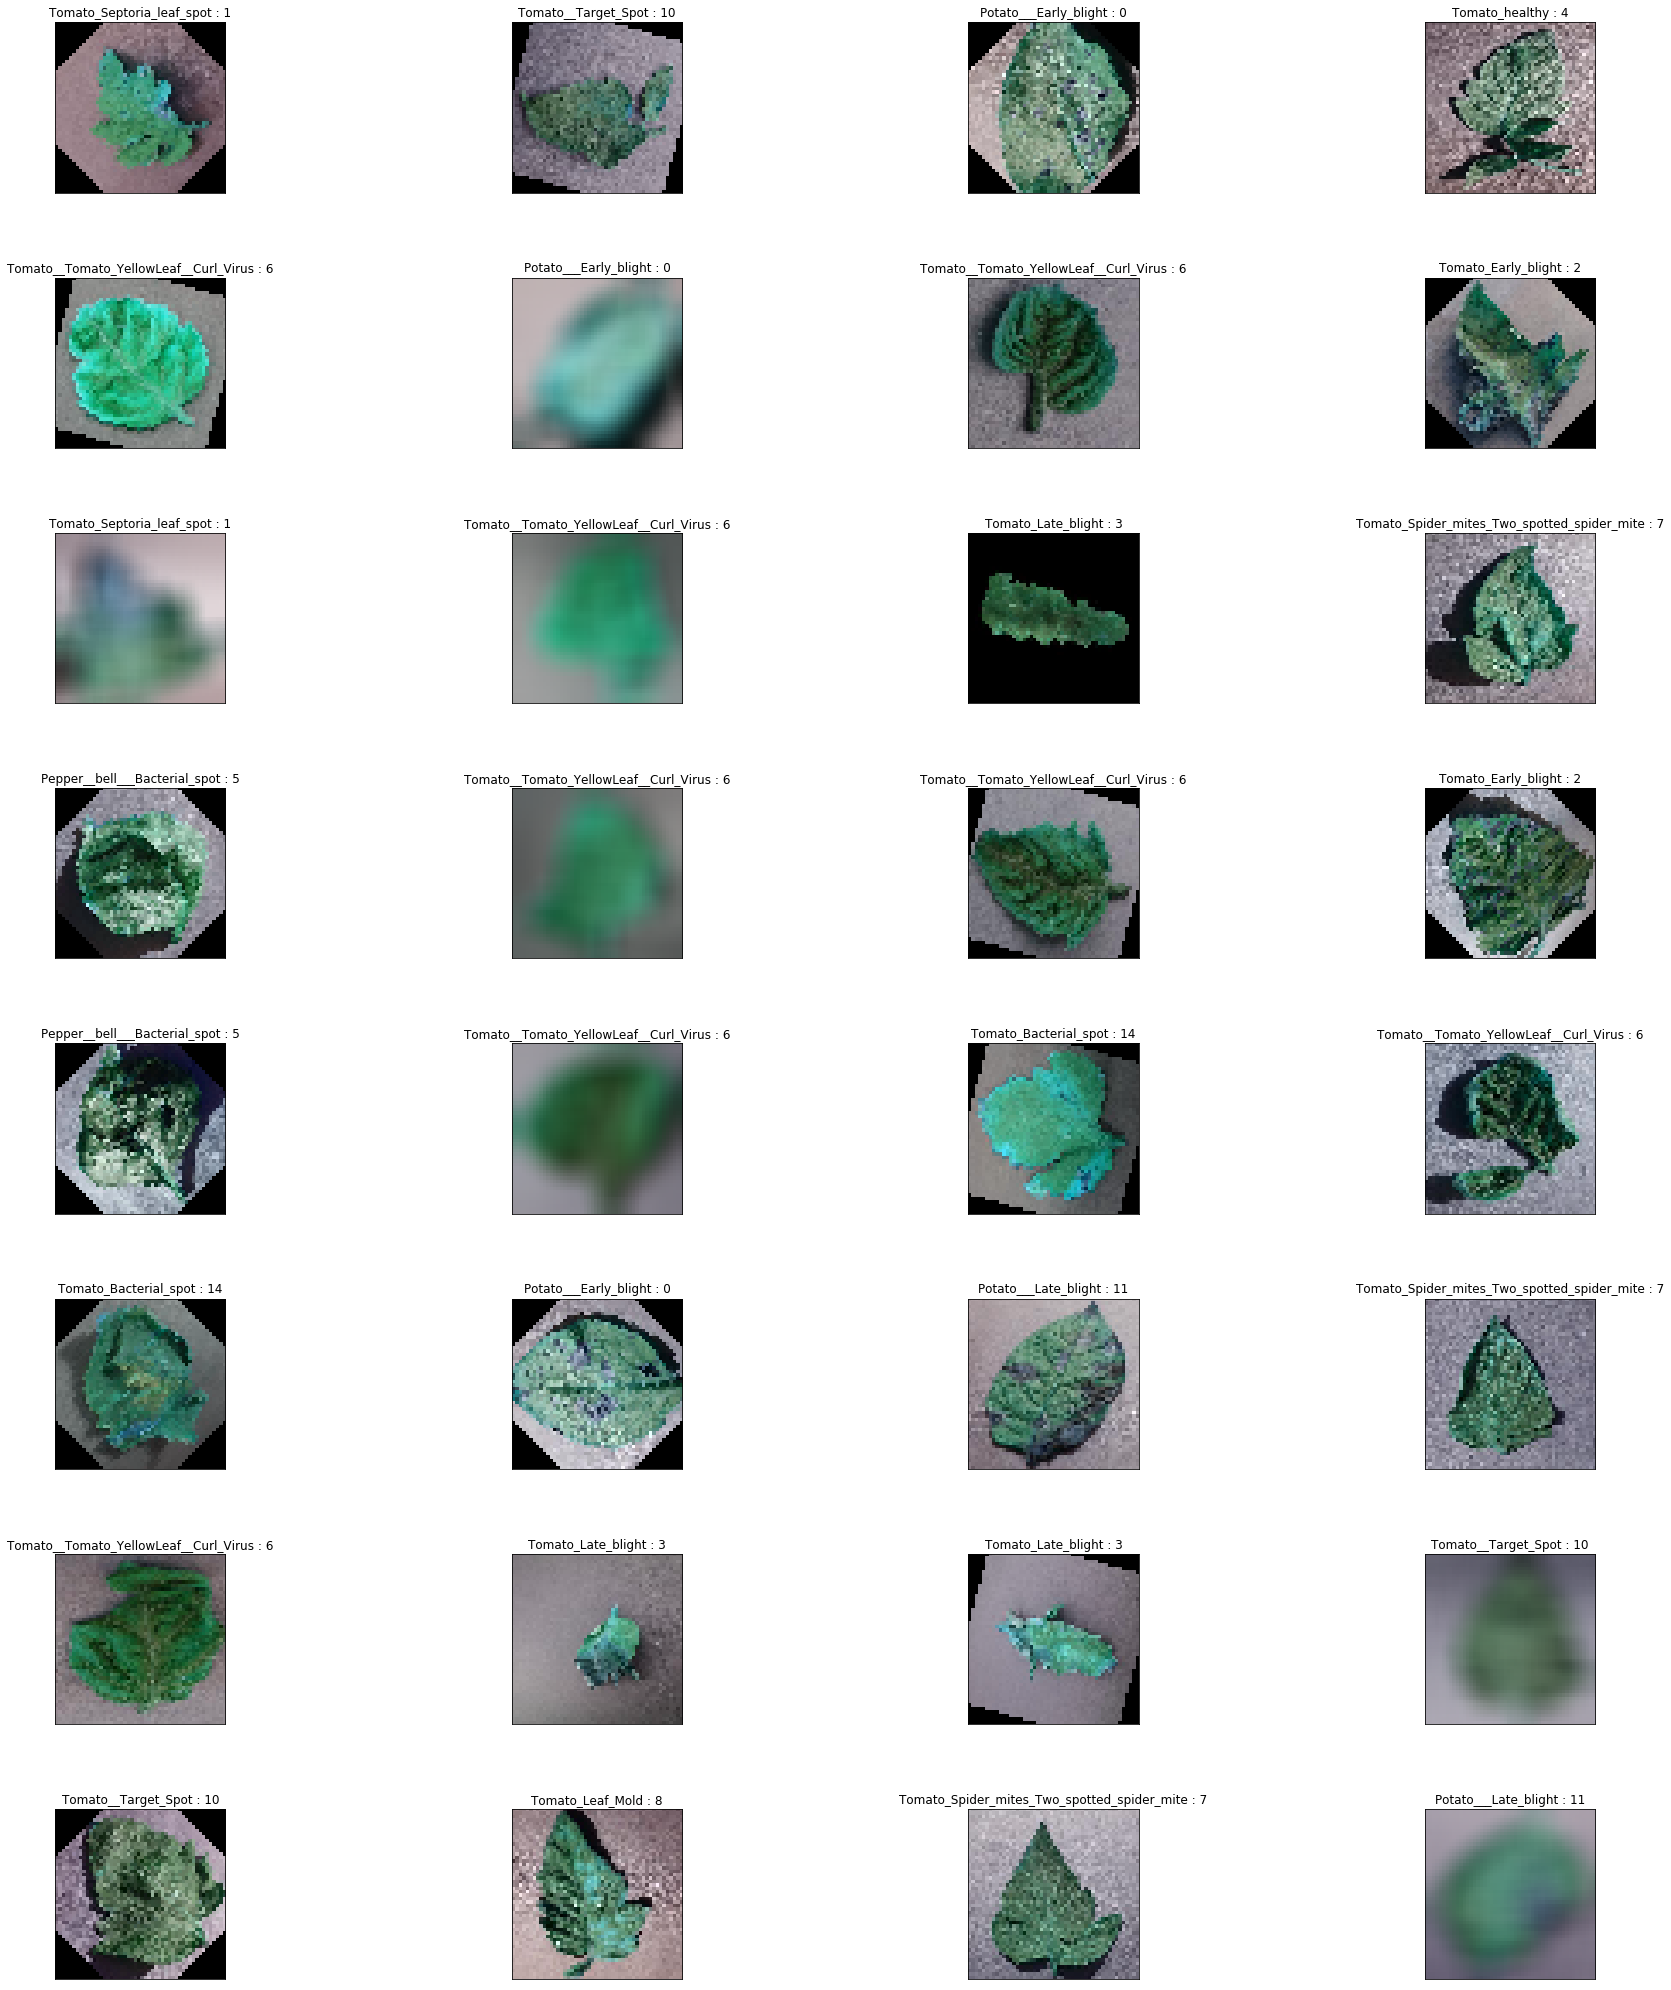

In [36]:
plt.figure(1 , figsize = (30 , 36))
n = 0 
for i in range(32):
    n += 1 
    r = np.random.randint(0 , plants.shape[0] , 1)
    plt.subplot(8 , 4 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(plants[r[0]])
    plt.title('{} : {}'.format(labelNames[labels[r[0]]] ,
                               labels[r[0]]) )
    plt.xticks([]) , plt.yticks([])
    
plt.show()

In [37]:
n = np.arange(plants.shape[0])
np.random.shuffle(n)
plants = plants[n]
labels = labels[n]
plants = plants.astype(np.float32)
labels = labels.astype(np.int32)
plants = plants/255

In [38]:
from sklearn.model_selection import train_test_split

train_x , x , train_y , y = train_test_split(plants , labels , 
                                            test_size = 0.2 ,
                                            random_state = 111)

eval_x , test_x , eval_y , test_y = train_test_split(x , y , 
                                                    test_size = 0.5 , 
                                                    random_state = 111)

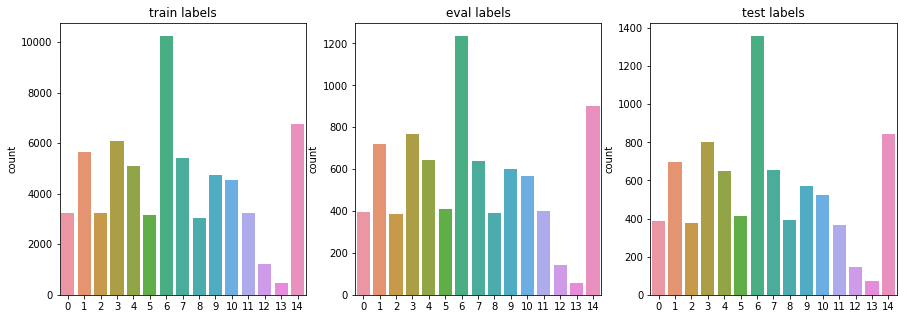

In [39]:
plt.figure(1 , figsize = (15 ,5))
n = 0 
for z , j in zip([train_y , eval_y , test_y] , ['train labels','eval labels','test labels']):
    n += 1
    plt.subplot(1 , 3  , n)
    sns.countplot(x = z )
    plt.title(j)
plt.show()

In [40]:
print('train data shape {} ,eval data shape {} , test data shape {}'.format(train_x.shape,
                                                                           eval_x.shape ,
                                                                           test_x.shape))

train data shape (66041, 50, 50, 3) ,eval data shape (8255, 50, 50, 3) , test data shape (8256, 50, 50, 3)


In [41]:
tf.reset_default_graph()
def cnn_model_fn(features , labels , mode):
    input_layers = tf.reshape(features['x'] , [-1 , 50 , 50 ,3])    
    conv1 = tf.layers.conv2d(
        inputs = input_layers , 
        filters = 50 , 
        kernel_size = [7 , 7],
        padding = 'same',
        activation = tf.nn.relu
        ) 
    
    
    conv2 = tf.layers.conv2d(
        inputs = conv1, 
        filters = 90,
        kernel_size = [3 , 3],
        padding = 'valid',
        activation = tf.nn.relu
        )

        
    conv3 = tf.layers.conv2d(
        inputs = conv2 ,
        filters = 10,
        kernel_size = [5 , 5],
        padding = 'same', 
        activation = tf.nn.relu
        )
    
    pool1 = tf.layers.max_pooling2d(inputs = conv3 , pool_size = [2 , 2] ,
                                    strides = 2 )
    conv4 = tf.layers.conv2d(
        inputs = pool1 ,
        filters = 5,
        kernel_size = [3 , 3],
        padding = 'same', 
        activation = tf.nn.relu
        )

    pool2 = tf.layers.max_pooling2d(inputs = conv4 , pool_size = [2 , 2] ,
                                    strides = 2 , padding = 'same')
    
    pool2_flatten = tf.layers.flatten(pool2)
    fc1 = tf.layers.dense(
        inputs = pool2_flatten,
        units = 2000,
        activation = tf.nn.relu
        )
    fc2 = tf.layers.dense(
        inputs = fc1,
        units = 1000,
        activation = tf.nn.relu
        )
    fc3 = tf.layers.dense(
        inputs = fc2 , 
        units = 500 ,
        activation = tf.nn.relu
        )
    logits = tf.layers.dense(
        inputs = fc3 ,
        units = 15
        )
    
    predictions = {
        'classes': tf.argmax(input = logits , axis = 1),
        'probabilities': tf.nn.softmax(logits , name = 'softmax_tensor')
    }
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode = mode , 
                                          predictions = predictions)
    
    loss = tf.losses.sparse_softmax_cross_entropy(labels = labels , 
                                                 logits = logits)
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.001)
        train_op = optimizer.minimize(loss = loss , 
                                      global_step = tf.train.get_global_step())
        
        return tf.estimator.EstimatorSpec(mode = mode , 
                                            loss = loss , 
                                            train_op = train_op 
                                           )
    eval_metric_op = {'accuracy' : tf.metrics.accuracy(labels = labels ,
                                         predictions =  predictions['classes'])}
    
    return tf.estimator.EstimatorSpec(mode = mode , 
                                      loss = loss , 
                                      eval_metric_ops = eval_metric_op)   

In [42]:
malaria_detector = tf.estimator.Estimator(model_fn = cnn_model_fn , 
                                         model_dir = '/tmp/modelchkpt')

In [43]:
tensors_to_log = {'probabilities':'softmax_tensor'}
logging_hook = tf.train.LoggingTensorHook(
    tensors = tensors_to_log , every_n_iter = 50 
    )
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x = {'x': train_x},
    y = train_y,
    batch_size = 100 , 
    num_epochs = None , 
    shuffle = True
    )
malaria_detector.train(input_fn = train_input_fn , steps = 1 , hooks = [logging_hook])

In [44]:
malaria_detector.train(input_fn = train_input_fn , steps = 120000)

In [45]:
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x = {'x': eval_x},
    y = eval_y , 
    num_epochs = 1 , 
    shuffle = False
    )
eval_results = malaria_detector.evaluate(input_fn = eval_input_fn)
print(eval_results)

{'accuracy': 0.9655966, 'loss': 0.17592219, 'global_step': 240003}


In [46]:
eval_input_fn = tf.estimator.inputs.numpy_input_fn( x = {'x': eval_x}, y = eval_y ,  num_epochs = 1 , shuffle = False)
eval_results = malaria_detector.evaluate(input_fn = eval_input_fn)
print(eval_results)

{'accuracy': 0.9655966, 'loss': 0.17592219, 'global_step': 240003}


In [47]:
pred_input_fn = tf.estimator.inputs.numpy_input_fn( x = {'x' : test_x}, y = test_y, num_epochs = 1, shuffle = False)

y_pred = malaria_detector.predict(input_fn = pred_input_fn)
classes = [p['classes'] for p in y_pred]

In [48]:
from sklearn.metrics import confusion_matrix , classification_report , accuracy_score
print('{} \n{} \n{}'.format(confusion_matrix(test_y , classes) , 
                           classification_report(test_y , classes) , 
                           accuracy_score(test_y , classes)))

[[ 387    0    0    0    0    0    0    0    1    0    0    1    0    0
     0]
 [   2  666    1    3    5    4    0    0    7    1    5    1    2    1
     1]
 [   1    1  347    5    0    3    2    3    2    0    7    1    0    0
     5]
 [   3    1    8  763    2    3    3    1    7    1    2    6    0    0
     1]
 [   0    3    0    1  638    0    0    0    0    0    4    0    0    0
     1]
 [   1    8    1    4    0  377    1    1    1   11    2    1    0    0
     3]
 [   0    2    3    2    0    0 1337    2    0    0    1    1    0    0
    10]
 [   0    0    6    0    0    0    0  641    0    0    8    0    1    0
     1]
 [   0    4    2    2    0    0    1    7  375    0    0    0    2    0
     0]
 [   0    1    5    2    0   10    1    0    1  548    0    2    0    0
     1]
 [   1    2    1    3    2    0    0    3    1    0  505    2    0    0
     2]
 [   2    3    0    3    0    0    0    0    0    1    2  357    0    0
     0]
 [   0    1    0    0    0    0    0    